# Project

In [28]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [29]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [30]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')
#print(close)

In [31]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})
#print(logret)

In [32]:
logret = logret.round(20)
#print(logret)

In [33]:
# define df with only stocks
df = logret
df.columns = tickers
ixic = df['IXIC']
stock = df
stock = stock.drop(['IXIC', 'NDXT'], axis=1)
#type(ixic)

# Data Analysis - use the historical data to predict the future

## Correlation 

In [34]:
# Define functions for actual/predicted volatility and the absolute error between them

def corpred(df, index, n):
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return (df.rolling(n).corr(index)[n-1::n]) # change to annualized volatility

def corAPE(df, index, n): # use absolute mean percentage error
    df_corpred = corpred(df, index, n)
    df_coract = df_corpred.shift(-1)
    df_corerr = (df_corpred - df_coract).iloc[:-1]  # delete the last NaN row
    df_corAMPE = (df_corerr.div(df_coract.iloc[:-1])).abs() # abs((actual-pred)/actual)
    df_corAMPE.columns=pd.MultiIndex.from_product([['APE (Correlation)'], df_corAMPE.columns])
    return df_corAMPE

def corAMPE(df, index, n): # use absolute mean percentage error
    df_corpred = corpred(df, index, n)
    df_coract = df_corpred.shift(-1)
    df_corerr = (df_corpred - df_coract).iloc[:-1]  # delete the last NaN row
    avg = (df_coract.iloc[:-1] + df_corpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_corAMPE = (df_corerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_corAMPE.columns=pd.MultiIndex.from_product([['AMPE (Correlation)'], df_corAMPE.columns])
    return df_corAMPE



In [35]:
corpred(stock, ixic, 5)

ticker,AAPL,AMD,BIDU,GOOGL,MSFT,NVDA,NXPI,QCOM,SWKS,TXN
Date,,,,,,,,,,
2011-06-08,0.090475,0.695090,0.825443,0.692451,0.190908,0.953554,-0.148200,0.934671,0.788800,0.874304
2011-06-15,0.965695,0.917698,0.864210,0.907640,0.789017,0.907718,0.935357,0.961177,0.867076,0.961781
2011-06-22,0.846544,0.933882,0.939708,0.806012,0.517207,0.880796,0.591397,0.803313,0.510563,0.983477
2011-06-29,0.742577,0.979942,0.824856,0.730663,0.822595,0.399572,0.588299,0.864273,0.492283,0.892804
2011-07-07,0.321471,0.854236,0.506596,0.666213,0.187615,0.942614,0.772392,0.654273,0.528700,0.874638
...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.903525,0.950045,-0.729093,0.371620,0.161446,0.990491,0.927761,0.830478,0.926252,0.715450
2021-05-07,0.836673,0.258155,0.781949,0.925901,0.947799,0.940868,0.805114,0.957126,0.499697,0.614947
2021-05-14,0.956670,0.813848,0.779298,0.974994,0.968134,0.956799,0.956922,0.906045,0.937856,0.982002


Text(0.5, 0.89, 'Predicted Correlation with Nasdaq Index (IXIC)')

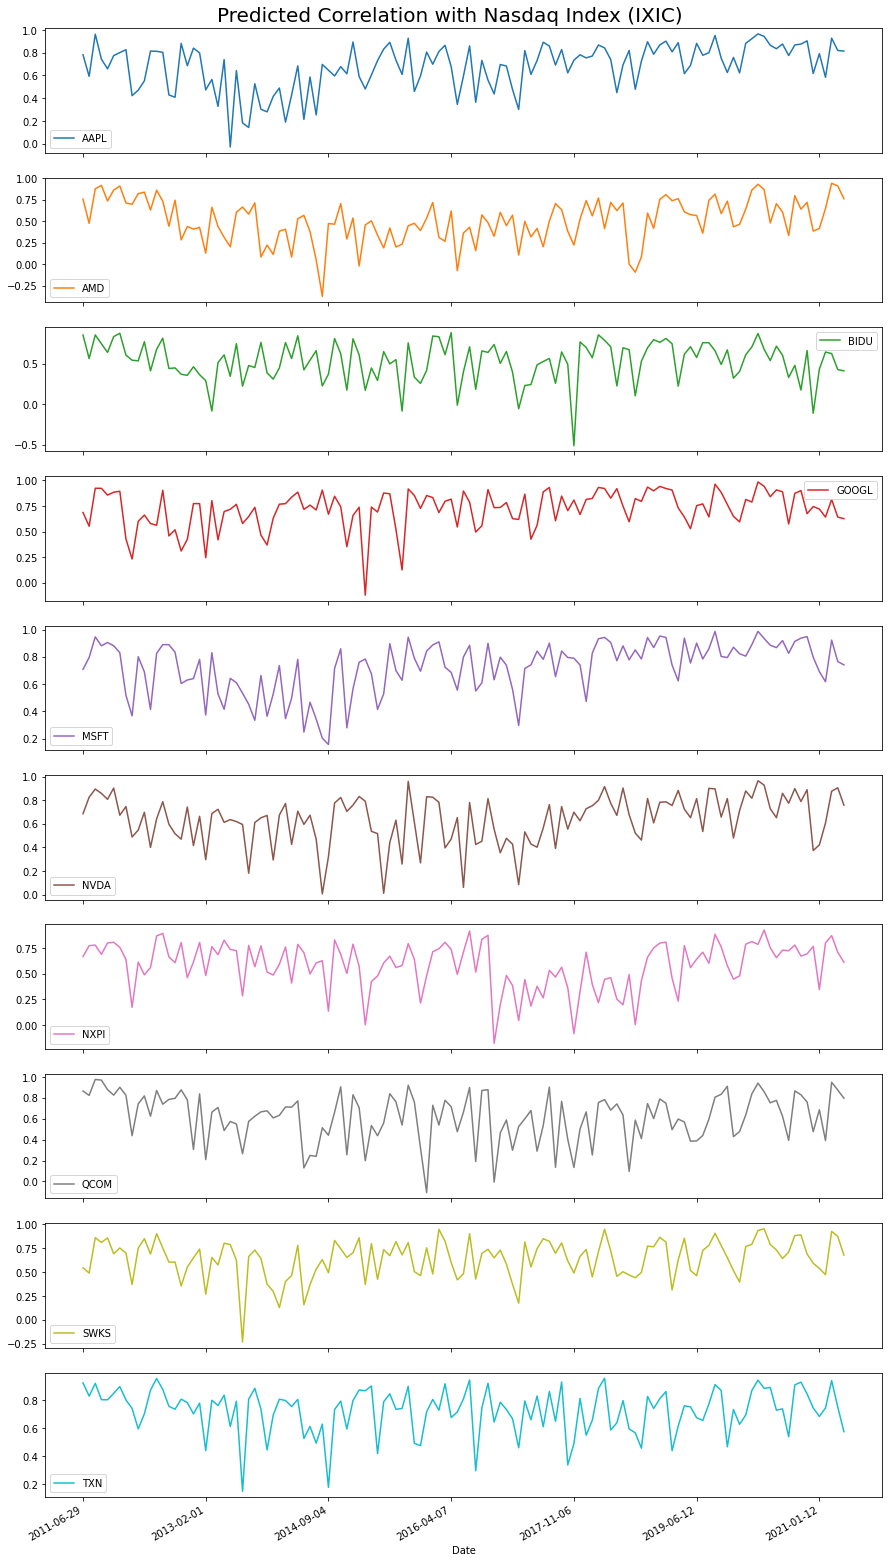

In [36]:
corpred(stock, ixic, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Correlation with Nasdaq Index (IXIC)", fontsize = 20, y = 0.89)

## Iterating through time windows 

In [37]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist_cor(function, df, index, tw):
    myerr = function(df, index, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

# define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail

# for volatility
def plotdot_cor(function, index, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((stock.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations greater than tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        myerr = function(stock, index, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null
            
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = stock.columns # rename the columns as the securities
    med = percent_T.median(axis=1)
    avg = percent_T.mean(axis=1)
    dotvalue = print(percent_T)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(function.__name__)
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Correlation with Nasdaq, Percentage of error observations greater than tail={tail}, {funcname.strip('cor')}")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg


In [38]:
def plotr2_cor(index, tw1, tw2, step):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((stock.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with r-squared values
    df_r2 = dfnan
    j = 0
    #k = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        df_corpred = corpred(stock, index, i)
        df_coract = df_corpred.shift(-1).iloc[:-1]
        df_corpred = df_corpred.iloc[:-1]
        
        for k in range(0, len(stock.columns), 1):
            # reshape the values of x(actual) and y(prediction) to (length,1) to use sklearn
            act = df_coract.iloc[:,k].values.reshape(len(df_coract.iloc[:,k]), 1)
            pred = df_corpred.iloc[:,k].values.reshape(len(df_corpred.iloc[:,k]), 1)
            md = linear_model.LinearRegression()
            md.fit(act, pred)
            r2 = md.score(act, pred)
            # fill in r2 into df_r2
            df_r2.iloc[k,j] = r2
        
        #k = k+1
        j = j+1
        
        # check infinity problem
        if df_corpred.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if df_corpred.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null

    
    df_r2_T = df_r2.transpose() # exchange x and y axis for plotting purpose
    df_r2_T.columns = stock.columns # rename the columns as the securities
    med = df_r2_T.median(axis=1)
    avg = df_r2_T.mean(axis=1)
    dotvalue = print(df_r2)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    #funcname = str(function.__name__)
    dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Correlation, R-squared from regression between actual and prediction")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg

ticker      AAPL       AMD      BIDU     GOOGL      MSFT      NVDA      NXPI  \
5       0.394422  0.605578  0.533865  0.338645  0.318725  0.412351  0.472112   
10      0.296000  0.476000  0.492000  0.284000  0.224000  0.356000  0.332000   
15      0.246988  0.373494  0.379518  0.192771  0.144578  0.349398  0.331325   
20      0.209677  0.395161  0.379032  0.153226  0.145161  0.250000  0.306452   
25      0.141414  0.323232  0.363636  0.080808  0.121212  0.232323  0.252525   
30      0.158537  0.231707  0.353659  0.121951  0.207317  0.195122  0.207317   
35      0.185714  0.314286  0.300000  0.085714  0.128571  0.185714  0.185714   
40      0.196721  0.295082  0.327869  0.131148  0.114754  0.180328  0.147541   
45      0.129630  0.240741  0.277778  0.055556  0.129630  0.185185  0.166667   
50      0.061224  0.204082  0.326531  0.081633  0.061224  0.183673  0.142857   
55      0.045455  0.250000  0.295455  0.045455  0.068182  0.136364  0.159091   
60      0.050000  0.150000  0.250000  0.

<AxesSubplot:title={'center':'Correlation with Nasdaq, Percentage of error observations greater than tail=0.5, APE'}>

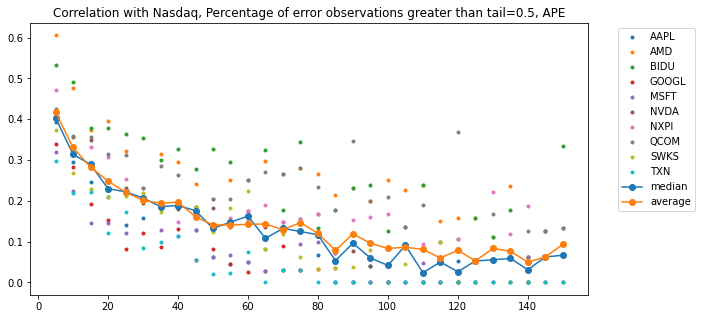

In [19]:
plotdot_cor(corAPE, ixic, 5, 150, 5, 0.5)[3]

ticker      AAPL       AMD      BIDU     GOOGL      MSFT      NVDA      NXPI  \
5       0.416335  0.607570  0.539841  0.338645  0.326693  0.412351  0.480080   
10      0.308000  0.484000  0.492000  0.296000  0.232000  0.388000  0.344000   
15      0.265060  0.397590  0.385542  0.192771  0.180723  0.331325  0.313253   
20      0.193548  0.395161  0.379032  0.153226  0.137097  0.250000  0.306452   
25      0.141414  0.323232  0.383838  0.080808  0.121212  0.222222  0.292929   
30      0.134146  0.268293  0.329268  0.121951  0.170732  0.170732  0.219512   
35      0.185714  0.300000  0.285714  0.157143  0.100000  0.200000  0.171429   
40      0.196721  0.327869  0.393443  0.098361  0.081967  0.180328  0.180328   
45      0.129630  0.296296  0.240741  0.074074  0.092593  0.185185  0.185185   
50      0.061224  0.265306  0.346939  0.040816  0.081633  0.122449  0.163265   
55      0.000000  0.295455  0.272727  0.000000  0.068182  0.113636  0.136364   
60      0.050000  0.175000  0.250000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Correlation with Nasdaq, Percentage of error observations greater than tail=0.5, AMPE'}>,
 <AxesSubplot:title={'center':'Correlation with Nasdaq, Percentage of error observations greater than tail=0.5, AMPE'}>,
 <AxesSubplot:title={'center':'Correlation with Nasdaq, Percentage of error observations greater than tail=0.5, AMPE'}>)

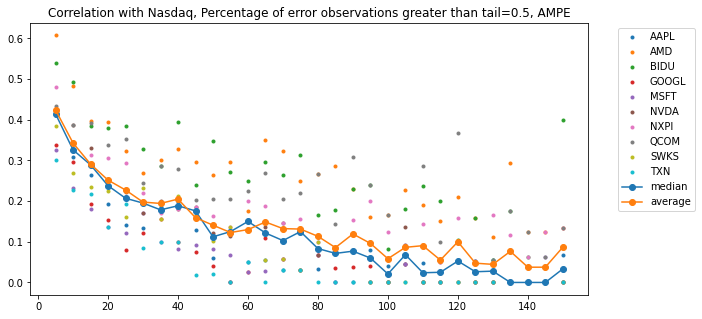

In [21]:
plotdot_cor(corAMPE, ixic, 5, 150, 5, 0.5)

        5         10        15        20        25        30        35   \
0  0.021038  0.073944  0.105885  0.119283  0.206021  0.158709  0.149648   
1  0.005303  0.060196  0.136038  0.169459  0.163796  0.226945  0.111186   
2  0.006872  0.023367  0.037136  0.004051  0.000126  0.002067  0.028095   
3  0.008517  0.005601  0.028165  0.039774  0.054401  0.033417  0.024531   
4  0.040237  0.095181  0.131159  0.205344  0.153376  0.100542  0.190531   
5  0.007920  0.003817  0.006086  0.066605  0.045635  0.193372  0.076116   
6  0.025343  0.088682  0.067222  0.099502  0.150907  0.191704  0.225198   
7  0.019249  0.028434  0.025651  0.016939  0.029021  0.035512  0.035277   
8  0.028951  0.019241  0.016796  0.044007  0.048081  0.017497  0.056373   
9  0.033688  0.017035  0.000035  0.001736  0.000031  0.004864  0.006203   

        40        45        50   ...       105       110       115       120  \
0  0.189375  0.196806  0.290401  ...  0.604155  0.504243  0.372984  0.472953   
1  0.133241  0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>)

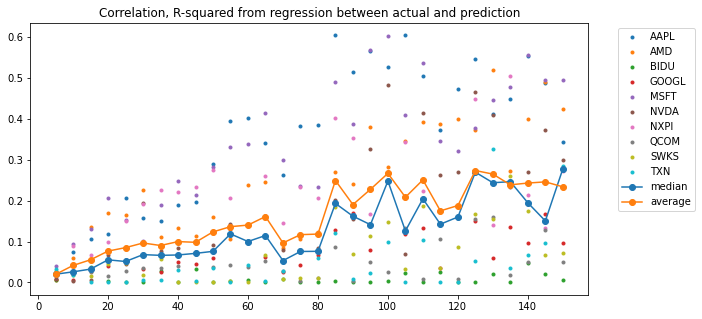

In [22]:
plotr2_cor(ixic, 5, 150, 5)

In [58]:
# create a NaN dataframe with rows as the time window, columns as the securities
col_names = [i for i in range(5, 155, 5)] # timewindow
# generate NaN entries
data = np.empty((stock.shape[1], len(col_names))) # number of rows = number of securities
# create dataframe
data[:] = np.nan
dfnan = pd.DataFrame(data, columns=col_names)
dfnan.iloc[0,0]

nan

In [52]:
df_coract.iloc[:,0]

Date
2011-09-09    0.703769
2011-12-19    0.508363
2012-03-30    0.715340
2012-07-11    0.579068
2012-10-18    0.644426
2013-02-01    0.571758
2013-05-14    0.256618
2013-08-22    0.395739
2013-12-02    0.275091
2014-03-14    0.395233
2014-06-24    0.568678
2014-10-02    0.757138
2015-01-13    0.535328
2015-04-24    0.717323
2015-08-04    0.760458
2015-11-11    0.786602
2016-02-24    0.586755
2016-06-03    0.593291
2016-09-13    0.593194
2016-12-21    0.487068
2017-04-04    0.788873
2017-07-14    0.650727
2017-10-23    0.749522
2018-02-02    0.774033
2018-05-15    0.577100
2018-08-23    0.810364
2018-12-03    0.864763
2019-03-18    0.748808
2019-06-26    0.843049
2019-10-04    0.699007
2020-01-15    0.952908
2020-04-27    0.756179
2020-08-05    0.871956
2020-11-12    0.691462
Name: AAPL, dtype: float64

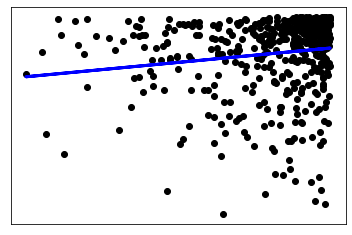

In [74]:
df_corpred = corpred(stock, ixic, 5)
df_coract = df_corpred.shift(-1).iloc[:-1]
df_corpred = df_corpred.iloc[:-1]
#df_coract.shape

#act = df_coract['AAPL'].values.reshape(len(df_coract['AAPL']), 1)
#pred = df_corpred['AAPL'].values.reshape(len(df_corpred['AAPL']), 1)

act = df_coract.iloc[:,0].values.reshape(len(df_coract.iloc[:,0]), 1)
pred = df_corpred.iloc[:,0].values.reshape(len(df_corpred.iloc[:,0]), 1)
md = linear_model.LinearRegression()
md.fit(act, pred)
md.score(act, pred)
plt.scatter(act, pred,  color='black')
plt.plot(act, md.predict(act), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [17]:
#md.fit(df_coract['AAPL'], df_corpred['AAPL'])
type(df_coract['AAPL'])

pandas.core.series.Series

In [123]:
df_corpred = corpred(stock, ixic, 70)
df_coract = df_corpred.shift(-1).iloc[:-1]
df_corpred = df_corpred.iloc[:-1]
#df_coract.shape
md = linear_model.LinearRegression()
md.fit(df_coract, df_corpred)
print(md.coef_)


[[ 6.80360023e-02  1.58728895e-01 -3.04386990e-01 -2.09103846e-01
   7.64578729e-01  2.85057291e-02  1.33291969e-01 -2.40735916e-01
  -2.34238763e-01  2.26810457e-01]
 [ 1.91918047e-01  2.20898195e-01 -2.36752502e-02 -4.74977289e-01
   2.44266906e-01  1.16011368e-01  6.09707951e-02 -2.49894305e-02
  -4.61944556e-01  2.12457919e-01]
 [ 2.35743183e-01 -4.90675361e-02  3.14350692e-01 -3.45688291e-01
   1.65081639e-01  1.19703050e-01  1.92936819e-01 -9.77287043e-02
  -6.95598685e-01  6.02856404e-02]
 [ 7.06283812e-02 -5.83809736e-02  1.84858296e-01 -1.06456895e-01
   1.47685991e-01  3.34348626e-01  1.41528383e-02 -2.49918422e-01
  -3.47203956e-03 -4.49417993e-01]
 [ 2.53744419e-01  2.38549388e-01 -1.88912902e-01 -1.43134371e-01
   6.54267022e-01 -2.35912537e-01  8.78800257e-02 -1.33886281e-01
  -2.60843697e-01 -1.25710263e-01]
 [-1.76424655e-02  6.61975488e-02 -2.75028060e-02 -1.83333859e-01
   2.75646609e-01  1.63645172e-01  3.63367615e-02 -1.32514524e-04
  -2.35419350e-01  1.48297124e-01

In [114]:
print(df_corpred.head())

ticker          AAPL       AMD      BIDU     GOOGL      MSFT      NVDA  \
Date                                                                     
2011-09-09  0.858191  0.726996  0.777005  0.738601  0.882434  0.844533   
2011-12-19  0.703769  0.789988  0.757444  0.866387  0.865608  0.817366   
2012-03-30  0.508363  0.737064  0.580451  0.332273  0.502175  0.582802   
2012-07-11  0.715340  0.754651  0.674592  0.680000  0.738280  0.664645   
2012-10-18  0.579068  0.342038  0.422278  0.441221  0.794282  0.571650   

ticker          NXPI      QCOM      SWKS       TXN  
Date                                                
2011-09-09  0.750610  0.943092  0.683763  0.860648  
2011-12-19  0.769880  0.861896  0.764095  0.848679  
2012-03-30  0.480032  0.733657  0.590152  0.737566  
2012-07-11  0.783910  0.745055  0.781638  0.874134  
2012-10-18  0.663179  0.818239  0.488686  0.733201  


In [ ]:
.isin([-1,1]).values.any()
findnull = meanAPE(logret,15)
findnull.columns = tickers
findnull = findnull.reset_index()
is_NaN = findnull.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = findnull[row_has_NaN]

print(rows_with_NaN)

In [68]:
df = corpred(stock, ixic, 70)
#df["AAPL"].between(-1,1).any()
df.ge(-1)&df.le(1)

ticker,AAPL,AMD,BIDU,GOOGL,MSFT,NVDA,NXPI,QCOM,SWKS,TXN
Date,,,,,,,,,,
2011-09-09,True,True,True,True,True,True,True,True,True,True
2011-12-19,True,True,True,True,True,True,True,True,True,True
2012-03-30,True,True,True,True,True,True,True,True,True,True
2012-07-11,True,True,True,True,True,True,True,True,True,True
2012-10-18,True,True,True,True,True,True,True,True,True,True
2013-02-01,True,True,True,True,True,True,True,True,True,True
2013-05-14,True,True,True,True,True,True,True,True,True,True
2013-08-22,True,True,True,True,True,True,True,True,True,True
2013-12-02,True,True,True,True,True,True,True,True,True,True


In [25]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist(function, df, tw):
    myerr = function(df, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

In [27]:
plothist(corAPE, stock, 20)

TypeError: corAPE() missing 1 required positional argument: 'n'

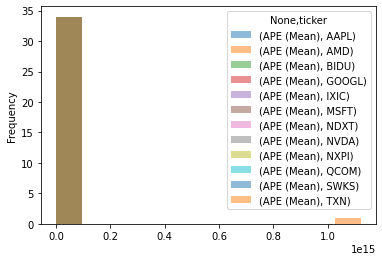

In [295]:
df = meanAPE(logret, 70).reset_index()
ax = df.plot.hist(bins=12, alpha=0.5)

In [281]:
trydf = meanAPE(logret, 70)
trydf.columns = tickers
trydf = trydf.reset_index()
print(trydf)
trydf[trydf['AMD'] > 3].groupby('business_id')['stars'].count()

ticker        Date      AAPL                     AMD     BIDU     GOOGL  \
0       2011-09-09  6.106649                0.149935 1.318864  1.008422   
1       2011-12-19  0.972340                1.586616 1.944909  4.516278   
2       2012-03-30 54.536783                2.012438 1.921204  1.265703   
3       2012-07-11  0.822287                0.207160 8.595730  1.589642   
4       2012-10-18  1.137132               80.433949 1.930848  0.788012   
5       2013-02-01 14.293437                1.015519 0.737287  0.183111   
6       2013-05-14  1.174003                4.085282 1.385021  9.831558   
7       2013-08-22  0.364024               20.444326 1.149876  1.080876   
8       2013-12-02  2.857179                0.837374 4.865637  0.768321   
9       2014-03-14  1.265267                1.190191 1.406245  5.267491   
10      2014-06-24  0.837151                1.153691 0.290721  2.723187   
11      2014-10-02  0.029957                0.380006 6.699475  1.098820   
12      2015-01-13  0.412

### Iterate through the time window